In [1]:
# ---------- FIRST LEVEL ANALYSIS ------------
# ---------------- Rat HRF -------------------

#Imports
import nilearn 
import pandas as pd
import numpy as np 
import nibabel as nib
import glob
import os
import matplotlib.pyplot as plt

from numpy import savetxt
from nilearn import plotting, image
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.first_level import compute_regressor
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
from IPython.display import Markdown, display

# Data path
analysis_folder='/project/4180000.19/multirat_stim/rabies/preprocess'
template_path ='/groupshare/traaffneu/preclinimg/templates/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Template.nii'
metadata_path ='/home/traaffneu/margal/code/multirat_se/script/table/metadata_stand.tsv'
mask = '/groupshare/traaffneu/preclinimg/templates/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Mask.nii'

# Output directories
output_dir = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/'
rat_hrf_gamma_diff_dir =  os.path.join(output_dir, 'rat_hrf_gamma_diff/')
rat_hrf_delay_disp_dir = os.path.join(output_dir, 'rat_hrf_delay_disp/')

gamma_matrix_dir = os.path.join(rat_hrf_gamma_diff_dir, 'matrix/')
gamma_image_dir = os.path.join(rat_hrf_gamma_diff_dir, 'image/')
gamma_model_dir = os.path.join(rat_hrf_gamma_diff_dir, 'model/')
gamma_beta_dir = os.path.join(rat_hrf_gamma_diff_dir, 'beta_estimates/')
gamma_residuals_dir = os.path.join(rat_hrf_gamma_diff_dir, 'residuals/')
gamma_effect_var_dir = os.path.join(rat_hrf_gamma_diff_dir, 'effect_var/')
gamma_predic_timeseries_dir = os.path.join(rat_hrf_gamma_diff_dir, 'predicted_timeseries/')
gamma_z_score_dir = os.path.join(rat_hrf_gamma_diff_dir, 'z_score/')

dd_matrix_dir = os.path.join(rat_hrf_delay_disp_dir, 'matrix/')
dd_image_dir = os.path.join(rat_hrf_delay_disp_dir, 'image/')
dd_model_dir = os.path.join(rat_hrf_delay_disp_dir, 'model/')
dd_beta_dir = os.path.join(rat_hrf_delay_disp_dir, 'beta_estimates/')
dd_residuals_dir = os.path.join(rat_hrf_delay_disp_dir, 'residuals/')
dd_effect_var_dir = os.path.join(rat_hrf_delay_disp_dir, 'effect_var/')
dd_predic_timeseries_dir = os.path.join(rat_hrf_delay_disp_dir, 'predicted_timeseries/')
dd_z_score_dir = os.path.join(rat_hrf_delay_disp_dir, 'z_score/')


if not os.path.exists(output_dir): os.makedirs(output_dir)
if not os.path.exists(gamma_matrix_dir): os.makedirs(gamma_matrix_dir)
if not os.path.exists(gamma_image_dir): os.makedirs(gamma_image_dir)
if not os.path.exists(gamma_model_dir): os.makedirs(gamma_model_dir)
if not os.path.exists(gamma_beta_dir): os.makedirs(gamma_beta_dir)
if not os.path.exists(gamma_residuals_dir): os.makedirs(gamma_residuals_dir)
if not os.path.exists(gamma_effect_var_dir): os.makedirs(gamma_effect_var_dir)
if not os.path.exists(gamma_predic_timeseries_dir): os.makedirs(gamma_predic_timeseries_dir)
if not os.path.exists(gamma_z_score_dir): os.makedirs(gamma_z_score_dir)

if not os.path.exists(dd_matrix_dir): os.makedirs(dd_matrix_dir)
if not os.path.exists(dd_image_dir): os.makedirs(dd_image_dir)
if not os.path.exists(dd_model_dir): os.makedirs(dd_model_dir)
if not os.path.exists(dd_beta_dir): os.makedirs(dd_beta_dir)
if not os.path.exists(dd_residuals_dir): os.makedirs(dd_residuals_dir)
if not os.path.exists(dd_effect_var_dir): os.makedirs(dd_effect_var_dir)
if not os.path.exists(dd_predic_timeseries_dir): os.makedirs(dd_predic_timeseries_dir)
if not os.path.exists(dd_z_score_dir): os.makedirs(dd_z_score_dir)
    
    
df = pd.read_csv(metadata_path, sep='\t')
df = df.loc[(df['exclude'] != 'yes')]

In [2]:
# --- Generic rat HRF: stim >5sec --- 

"""
Implement the rat response function model. Ref: 
 - Matlab script H. Lambert (2019)
 - and nilearn example : https://app.codecov.io/gh/nilearn/nilearn/pull/2942/blob/nilearn/glm/first_level/hemodynamic_models.py

    Parameters
    ----------
    tr: float
        scan repeat time, in seconds
    oversampling: int, optional
        temporal oversampling factor
    onset: float, optional
        hrf onset time, in seconds

    Parameters gamma func
    ---------------------
    time_length : stimulation duration in seconds, must be defined before running the function
    tr : in seconds
    h1, h2, l1, and l2 : define the shape and scale parameters
    V = ratio parameter 
    
    Returns
    -------
    response_function: array of shape(length / tr * oversampling, dtype=float)
        response_function sampling on the oversampled time grid

""" 

from scipy.stats import gamma
np.printoptions(False)

def rat_hrf_gamma_diff(tr, oversampling=16, onset=0.0 ):
    dt = tr / oversampling
    #time_length = duration + onset
    time_stamps = np.linspace(0, time_length, np.rint(time_length / dt).astype(int))
    time_stamps -= onset
     
    # Parameters of the gamma function
    h1 = 3.7
    h2 = 4.45
    l1 = 0.5
    l2 = 0.5
    V = 1.5

    response_function = (gamma.pdf(time_stamps, h1 / l1, scale=1 / l1) -
                         gamma.pdf(time_stamps, h2 / l2, scale=1 / l2)) / V
    
    response_function /= response_function.sum()
    response_function *= 1
   
    return response_function

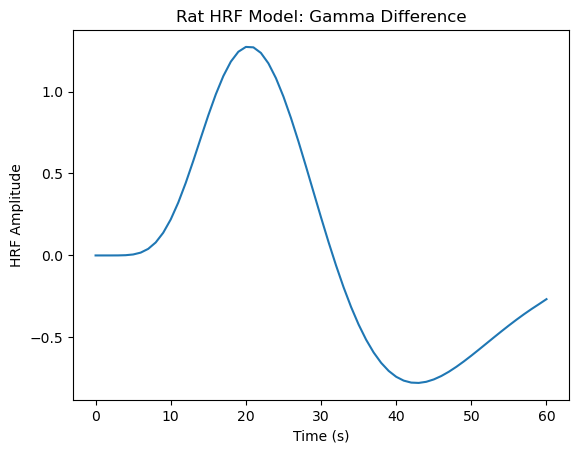

In [3]:
time_length = 30
oversampling = 16
frame_times = np.linspace(0, time_length, 61)
onset, amplitude, duration = 0.0, 1.0, 1.0
exp_condition = np.array((onset, duration, amplitude)).reshape(3, 1)

signal, _labels = compute_regressor(exp_condition=exp_condition,
                                    hrf_model=rat_hrf_gamma_diff,
                                    frame_times=frame_times)

plt.plot(signal)
plt.xlabel('Time (s)')
plt.ylabel('HRF Amplitude')
plt.title('Rat HRF Model: Gamma Difference')
plt.show()

In [4]:
# --- Rat HRF --- 

#ref: 10.1002/mrm.21246 

import numpy as np
from scipy.stats import gamma

"""
Implement the rat response function model.

    Parameters
    ----------
    tr: float
        scan repeat time, in seconds
    oversampling: int, optional
        temporal oversampling factor
    onset: float, optional
        hrf onset time, in seconds

    Returns
    -------
    response_function: array of shape(length / tr * oversampling, dtype=float)
        response_function sampling on the oversampled time grid
"""

def rat_hrf_delay_disp(tr, oversampling=16, onset=0.0):
    
    dt = tr / oversampling
    time_stamps = np.linspace(0, time_length, np.rint(time_length / dt).astype(int))
    time_stamps -= onset

    # parameters of the gamma function
    delay = 2.18
    dispersion = 1.92

    response_function = gamma.pdf(time_stamps, delay, loc=0, scale=dispersion)
    response_function /= response_function.sum()

    return response_function

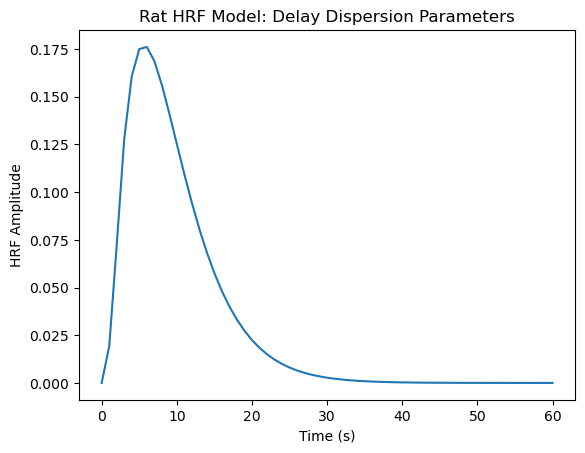

In [5]:
time_length = 30
oversampling = 16
frame_times = np.linspace(0, time_length, 61)
onset, amplitude, duration = 0.0, 1.0, 1.0
exp_condition = np.array((onset, duration, amplitude)).reshape(3, 1)

signal, _labels = compute_regressor(exp_condition=exp_condition,
                                    hrf_model=rat_hrf_delay_disp,
                                    frame_times=frame_times)

plt.plot(signal)
plt.xlabel('Time (s)')
plt.ylabel('HRF Amplitude')
plt.title('Rat HRF Model: Delay Dispersion Parameters')
plt.show()

The chosen HRF model is: <function rat_hrf_delay_disp at 0x7fa2aca1f820>
index: 0
subj: 200100
TR: 2.0
n stim: 3
stim duration: 20
Contrasts:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/_utils/glm.py:335: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1. / X)


index: 1
subj: 200101
TR: 2.0
n stim: 3
stim duration: 20
Contrasts:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/_utils/glm.py:335: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1. / X)


index: 2
subj: 200102
TR: 2.0
n stim: 3
stim duration: 20
Contrasts:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/_utils/glm.py:335: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1. / X)


index: 3
subj: 200103
TR: 2.0
n stim: 3
stim duration: 20
Contrasts:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/_utils/glm.py:335: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1. / X)


index: 4
subj: 200104
TR: 2.0
n stim: 3
stim duration: 20
Contrasts:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/_utils/glm.py:335: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1. / X)


index: 5
subj: 200105
TR: 2.0
n stim: 3
stim duration: 20
Contrasts:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/_utils/glm.py:335: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1. / X)


index: 6
subj: 200106
TR: 2.0
n stim: 3
stim duration: 20
Contrasts:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/_utils/glm.py:335: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1. / X)


index: 7
subj: 200107
TR: 2.0
n stim: 3
stim duration: 20
Contrasts:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/_utils/glm.py:335: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1. / X)


index: 8
subj: 200108
TR: 2.0
n stim: 3
stim duration: 20
Contrasts:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
index: 9
subj: 200109
TR: 2.0
n stim: 3
stim duration: 20
Contrasts:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


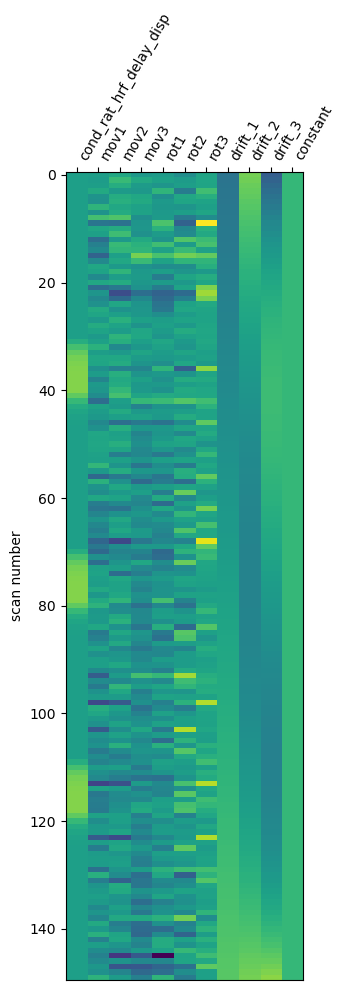

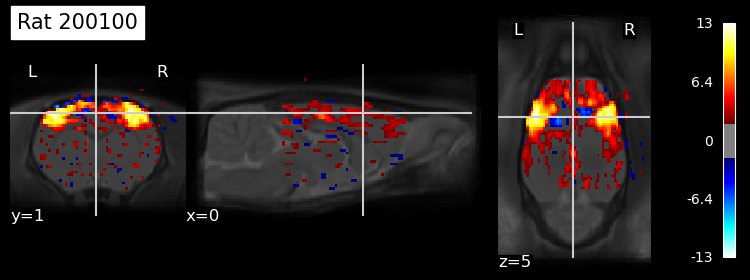

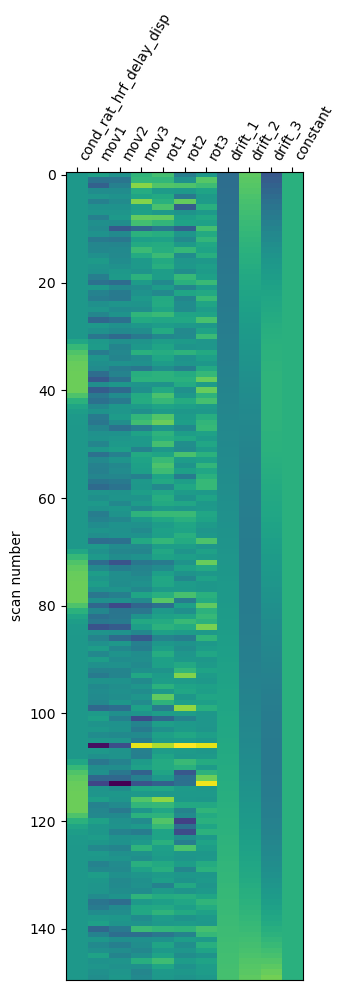

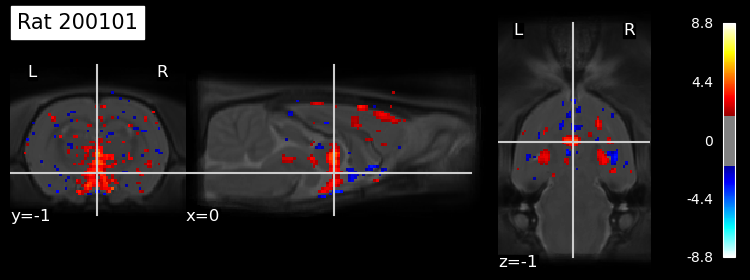

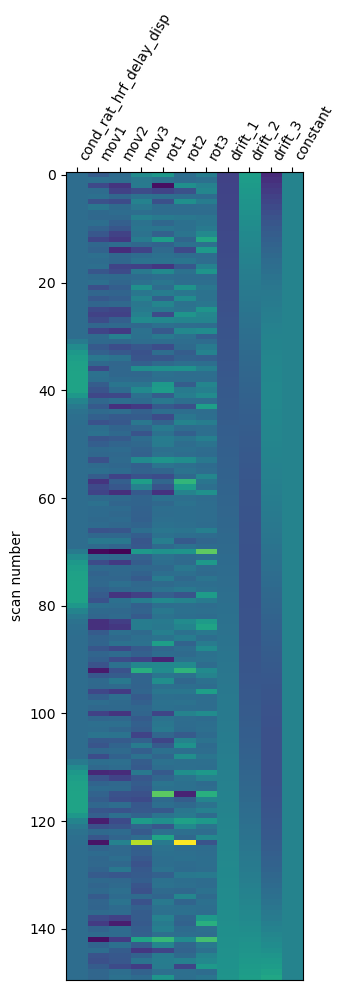

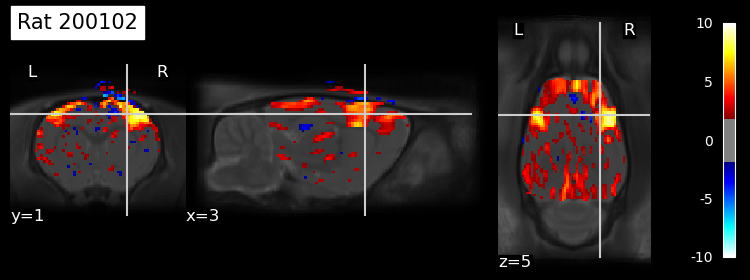

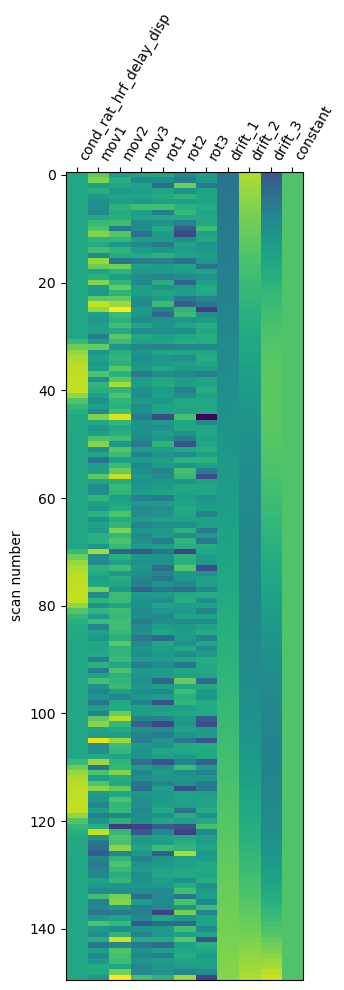

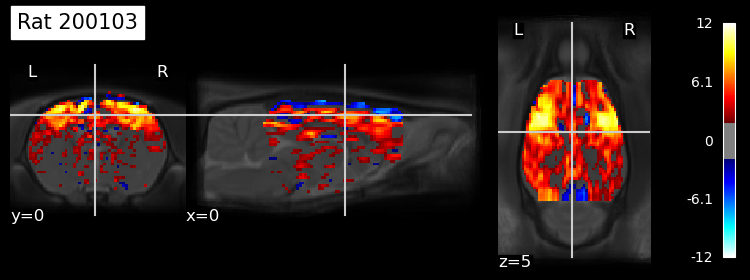

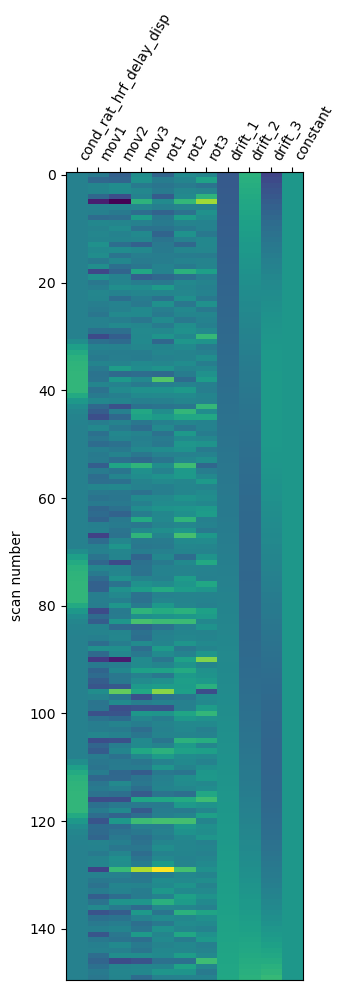

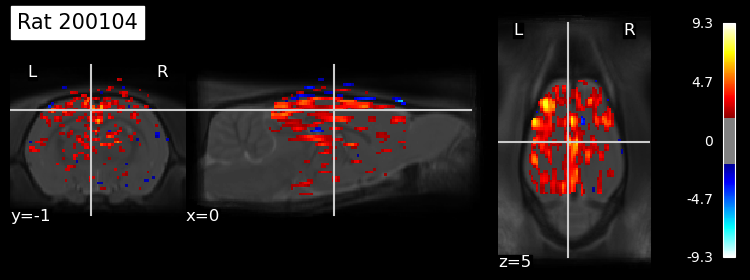

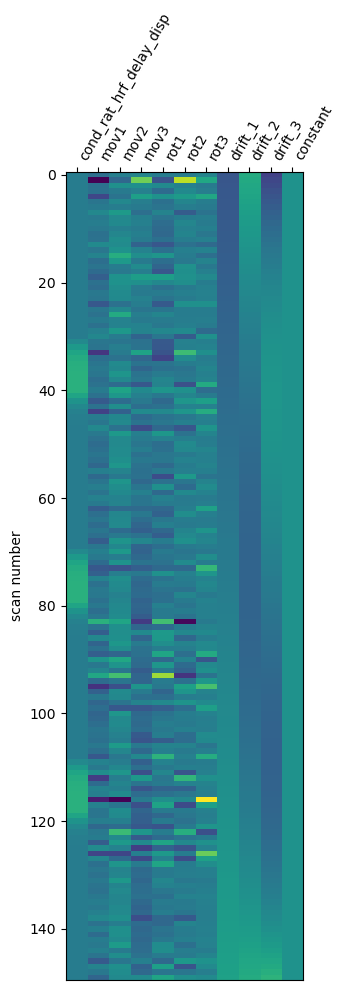

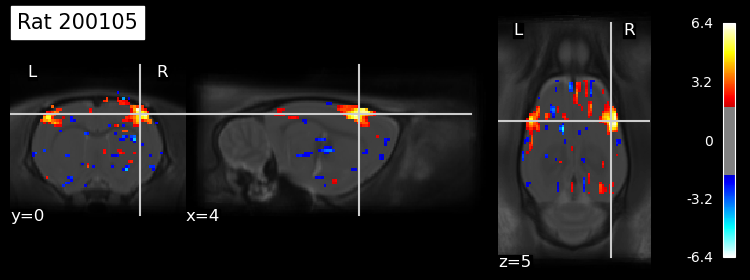

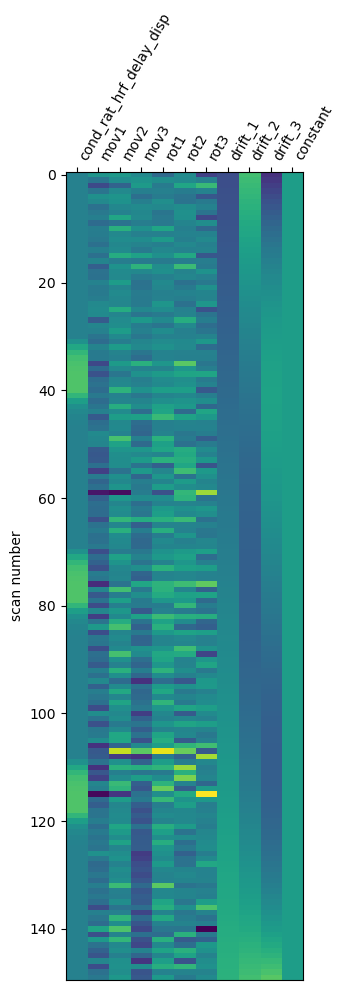

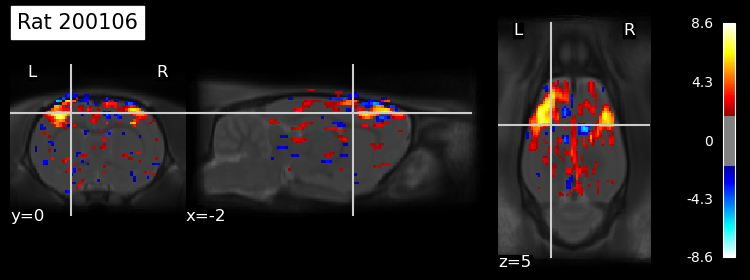

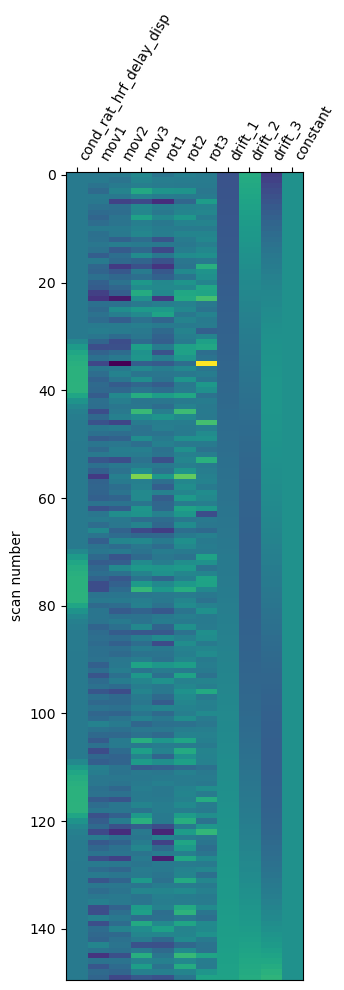

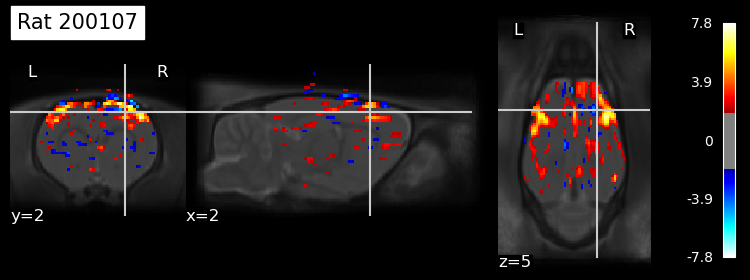

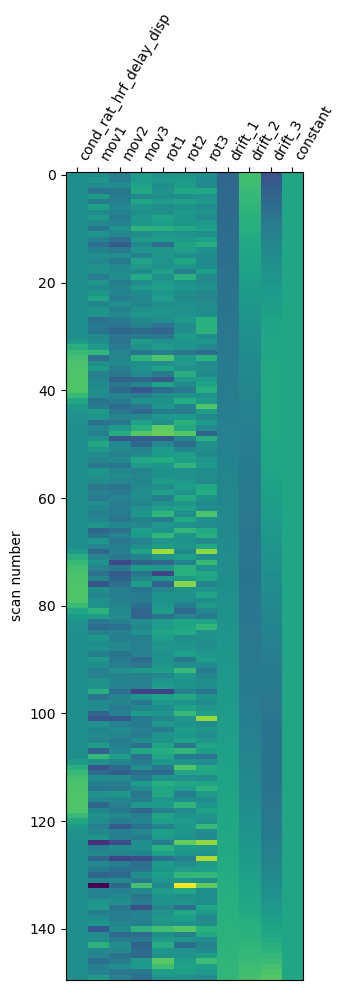

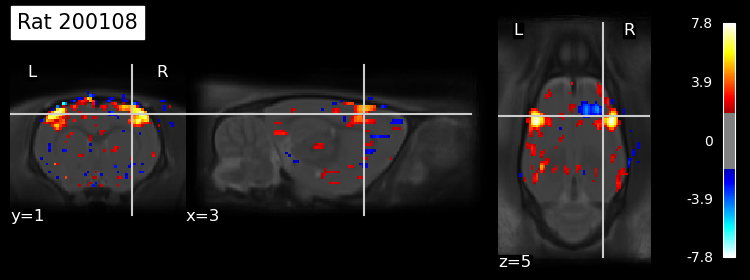

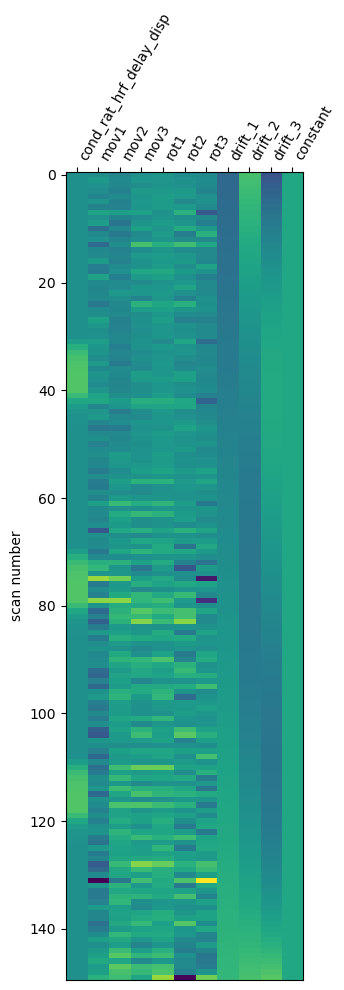

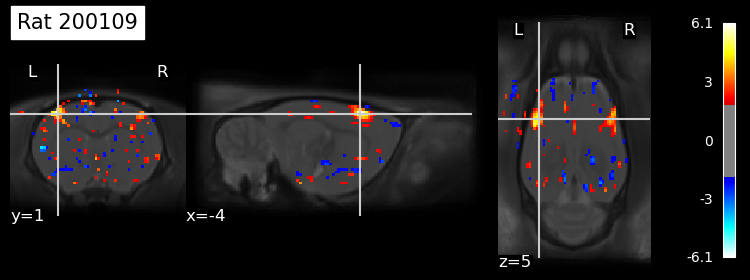

In [6]:
# ---------- FIRST LEVEL ANALYSIS ------------
# ---------------- Rat HRF -------------------

# --- Hrf model to be used ---

""" Define hrf model used for the first analysis
    Options : 
    ---------
    rat_hrf_delay_disp
    rat_hrf_gamma_diff
"""
#hrf_function = rat_hrf_gamma_diff
hrf_function = rat_hrf_delay_disp
print('The chosen HRF model is:', hrf_function)


for index in range(0, 10):
    
    subj_num=str(df.iloc[index]['rat.sub'])[:-2]
    print('index:', index)
    print('subj:', subj_num)
    
    subject_path = glob.glob(analysis_folder + "/sub-0{}_ses-1/bold_datasink/commonspace_bold/*/*/*.nii.gz".format(subj_num, subj_num, subj_num))[0]
    func_img = nib.load(subject_path) 
    
     # --- Events regressor --- 
    
    n_scans = func_img.shape[3]   
    tr = (df.iloc[index]['func.TR']) 
    n_tr = np.count_nonzero((np.matrix(df.iloc[index]['func.sensory.onset'])))   #count number of stimulation, number of onset
    frame_times = np.arange(n_scans) * tr 
    
    onset_metadata = np.matrix(df.iloc[index]['func.sensory.onset']).A[0]  # Get onsets from metadata file
    scan_start_times = frame_times[:n_tr]                                  # Get the start times of each scan
    
    if len(onset_metadata) != len(scan_start_times):
        onsets = onset_metadata 
        warning = '**WARNING: number of onset in onset_metadata are diff than number of TR in scan_start_times**'
        display(Markdown(warning))
    else:
        onsets = onset_metadata - scan_start_times  # Subtract the start time of each scan

    durations = np.matrix(df.iloc[index]['func.sensory.duration']).A[0]
    trial_type = np.ones_like(onsets)
    events = pd.DataFrame({'trial_type': trial_type,'onset': onsets,'duration': durations})
    
    # --- Rat HRF regressor --- 
    
    exp_condition = np.array((onsets, durations, trial_type))
    time_length = int(df.iloc[index]['func.sensory.duration'].split(',')[0].strip())
    
    rat_hrf_model, _labels_hrf = compute_regressor(exp_condition, hrf_function, frame_times)
    
    print('TR:', tr)
    print('n stim:', n_tr)
    print('stim duration:', time_length)
    
    # --- Motion regressors ---

    cofounders_file = 'sub-0{}_ses-1_run-1_bold_RAS_combined_confounds.csv'.format(subj_num)
    cofounders_path = glob.glob(analysis_folder +"/sub-0{}_ses-1/confounds_datasink/confounds_csv/*/*/*.csv".format(subj_num, subj_num, subj_num, subj_num))[0]

    cofounders = pd.read_csv(cofounders_path, sep=',')

    motion_names = ['mov1', 'mov2', 'mov3', 'rot1', 'rot2', 'rot3']
    motion = np.array(cofounders[motion_names])
    
    all_regressors = np.column_stack((rat_hrf_model, motion))
    all_reg_names = _labels_hrf + motion_names

    # --- Compute design matrix --- 
    
    full_design_matrix = make_first_level_design_matrix(frame_times=frame_times, 
                                                   events=events, 
                                                   add_regs=all_regressors,
                                                   add_reg_names=all_reg_names, 
                                                   drift_model="polynomial", 
                                                   drift_order=3, 
                                                   hrf_model=None,
                                                   high_pass=0.01)
    
 
    design_matrix = full_design_matrix.drop(1.0, axis=1)   # remove first column which is the block design
    #design_matrix = full_design_matrix
    plot_design_matrix(design_matrix) 
    
    
    # --- Fitting a first-level model ----  
    
    fmri_glm = FirstLevelModel(t_r=tr,
                                drift_model='polynomial',
                                signal_scaling=False,
                                minimize_memory=False)
    
    fmri_glm = fmri_glm.fit(subject_path, design_matrices=design_matrix)

    residuals = fmri_glm.residuals[0]
    predicted_timeseries = fmri_glm.predicted[0]
    
    # -- Compute contrasts ---
    
    n_columns = design_matrix.shape[1]
    contrast_val = np.hstack(([1], np.zeros(n_columns - 1)))
    print('Contrasts: ', contrast_val)

    statistical_map = fmri_glm.compute_contrast(contrast_val, output_type='all')
    
    #-- Plot and save as nifti file ---
    
    plot_stat = plotting.plot_stat_map(statistical_map['z_score'], 
                                        bg_img = template_path, 
                                        threshold = 1.9, 
                                        title = 'Rat {}'.format(subj_num))
    
    #-- Save outputs --  
    
    if hrf_function == rat_hrf_gamma_diff:
        savetxt(gamma_matrix_dir+'matrix_sub-0{}_ses-1.csv'.format(subj_num), design_matrix, delimiter=',')
        nib.save(statistical_map['effect_size'], gamma_beta_dir+'beta_sub-0{}_ses-1.nii.gz'.format(subj_num))    #save the betaestimates
        nib.save(residuals, gamma_residuals_dir+'residuals_sub-0{}_ses-1.nii.gz'.format(subj_num))               #save this to nifti
        nib.save(predicted_timeseries, gamma_predic_timeseries_dir+'predicted_timeseries_sub-0{}_ses-1.nii.gz'.format(subj_num))  
        nib.save(statistical_map['z_score'], gamma_z_score_dir+'z_score_sub-0{}_ses-1.nii.gz'.format(subj_num))  #save z map
        nib.save(statistical_map['effect_variance'], gamma_effect_var_dir+'effect_var_sub-0{}_ses-1.nii.gz'.format(subj_num))  #save the betaestimates
        plt.savefig(gamma_image_dir+'stat_map_sub-0{}_ses-1.png'.format(subj_num))
        
    elif hrf_function == rat_hrf_delay_disp:
        savetxt(dd_matrix_dir+'matrix_sub-0{}_ses-1.csv'.format(subj_num), design_matrix, delimiter=',')
        nib.save(statistical_map['effect_size'], dd_beta_dir+'beta_sub-0{}_ses-1.nii.gz'.format(subj_num))     #save the betaestimates
        nib.save(residuals, dd_residuals_dir+'residuals_sub-0{}_ses-1.nii.gz'.format(subj_num))                #save this to nifti
        nib.save(predicted_timeseries, dd_predic_timeseries_dir+'predicted_timeseries_sub-0{}_ses-1.nii.gz'.format(subj_num))  
        nib.save(statistical_map['z_score'], dd_z_score_dir+'z_score_sub-0{}_ses-1.nii.gz'.format(subj_num))   #save z map
        nib.save(statistical_map['effect_variance'], dd_effect_var_dir+'effect_var_sub-0{}_ses-1.nii.gz'.format(subj_num))  #save the betaestimates
        plt.savefig(dd_image_dir+'stat_map_sub-0{}_ses-1.png'.format(subj_num))
        
    else:
        print('No file to be saved. Check that hrf_function is well defined.')
        

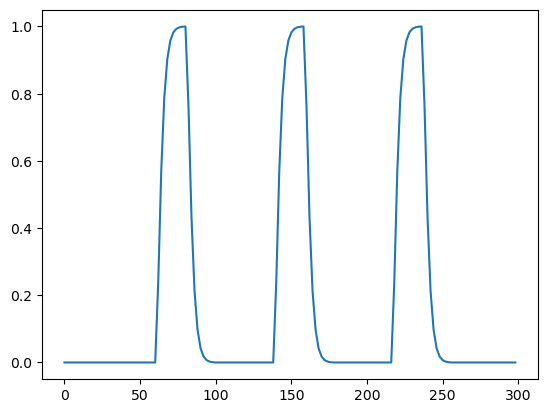

In [26]:
#rat_hrf_delay_diff model
model = design_matrix['cond_rat_hrf_delay_disp']
plt.plot(model)
savetxt(dd_model_dir+'model_sub-0{}_ses-1.csv'.format(subj_num), model, delimiter=',')


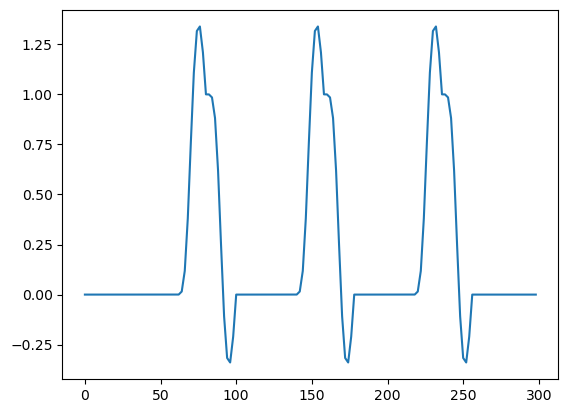

In [28]:
#rat_hrf_gamma_diff model
model = design_matrix['cond_rat_hrf_gamma_diff']

plt.plot(model)
savetxt(gamma_model_dir+'model_sub-0{}_ses-1.csv'.format(subj_num), model, delimiter=',')


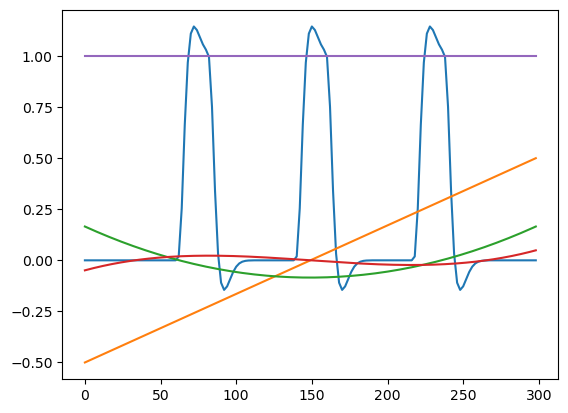

In [89]:
#spm model
plt.plot(design_matrix)

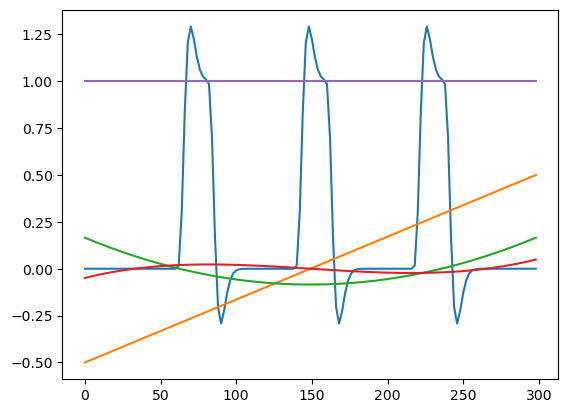

In [86]:
#glover model 
plt.plot(design_matrix)